# A general algorithm for microscope image deconvolution

In [1]:
# !conda activate py37
# !conda install pandas numpy matplotlib pytorch --yes

Below are notes for my own mind - *tl;dr pytorch is a bit juvenile for the approach I'm taking but I have some very promising results using some known sparse iterative (least squares) solvers.*

-   Pytorch is great but it's not doing so well with sparse matrices
    -   Due to some quirk sparse matrices crash my sessions
    -   GPU support for sparse matrices is not yet ready but coming soon
    -   It does have great optimizers that I'd like to use though
-   LSMR and LSQR (both on scipy) work great: [https://arxiv.org/abs/1006.0758](https://www.google.com/url?q=https://arxiv.org/abs/1006.0758&sa=D&source=calendar&ust=1601742525484000&usg=AOvVaw03I9SO2ctTuh74cfPUWb_A)
    -   I'm getting edge effects but compared to richardson lucy the results are excellent
    -   They also work with rectangular matrices which is ideal, except for the fact that finding an appropriate initial guess isn't trivial.
    -   There is a gpu based version for these algorithms too:
        -   [https://docs.cupy.dev/en/stable/reference/generated/cupyx.scipy.sparse.linalg.lsqr.html](https://www.google.com/url?q=https://docs.cupy.dev/en/stable/reference/generated/cupyx.scipy.sparse.linalg.lsqr.html&sa=D&source=calendar&ust=1601742525484000&usg=AOvVaw0Watfm6hRqMsA6ZvDrlwb2)
-   [pyro.ai](https://www.google.com/url?q=http://pyro.ai&sa=D&source=calendar&ust=1601742525484000&usg=AOvVaw0twSi-hR_g21J62AtDi45o) - this is a whole rabbit hole of a separate project with huge scope for solving SMLM problems that have a time component. Once this project is well packaged and usable I'll add the time element.
-   Learning the measurement matrix
    -   Using a random forest regressor for the simple case of a PSF that slightly widens at the edge of an image seems to be working very well
    -   Need to apply this to something less linear like SIM or Airybeam data.
-   Future, I think it'd be really handy to the community for me to package this all neatly and put it on PyPi and conda
    -   However, for large 3D images it may be that gpus are the only real way of applying this deconvolution.

In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import PIL
import scipy
from IPython.display import Video
from tqdm import tqdm
import multiprocessing
import os
import skimage
from enum import Enum,auto

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.metrics import mean_squared_error


# from sklearn import neural_network, metrics, gaussian_process, preprocessing, svm, neighbors
# from sklearn import pipeline, model_selection

# from keras import metrics
# from keras import backend as K
from scipy.stats import pearsonr
from sklearn import svm, linear_model
# import microscPSF.microscPSF as msPSF
from skimage.metrics import structural_similarity as ssim

from scipy import matrix
from scipy.sparse import coo_matrix
import time
from scipy import linalg
from skimage import color, data, restoration, exposure
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import convolve2d as conv2
# import matlab.engine

# from sklearn.preprocessing import Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.experimental import enable_iterative_imputer
from scipy import signal
from sklearn.impute import SimpleImputer

class psf_switch_enum(Enum):
    STATIC,VAR_PSF,VAR_ILL = auto(),auto(),auto()
    
SAVE_IMAGES = 0

# Image formation

Define constants: psf height width and image rescaling factor

In [3]:
psf_w,psf_h,scale = 64,64,4 # Define constants: psf height width and image rescaling factor
psf_window_w, psf_window_h = round(psf_w/scale), round(psf_h/scale)
sigma = 1

Define approximate PSF function 

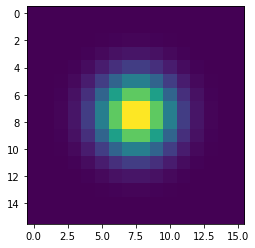

In [4]:
def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
def psf_guass(w=psf_w, h=psf_h, sigma=3):
    # blank_psf = np.zeros((w,h))
    xx, yy = np.meshgrid(np.linspace(-1, 1, w), np.linspace(-1, 1, h))
    psf = gaussian(xx, 0, sigma) * gaussian(yy, 0, sigma)
    return  psf/psf.sum() # Normalise PSF "energy"

static_psf = psf_guass(w=round(psf_window_h), h=round(psf_window_w), sigma=1 / scale); plt.imshow(static_psf) 

In [5]:
Video("eiffel_smlm.mp4",embed=True) # Credit: Ricardo Henriques

# Deconvolution

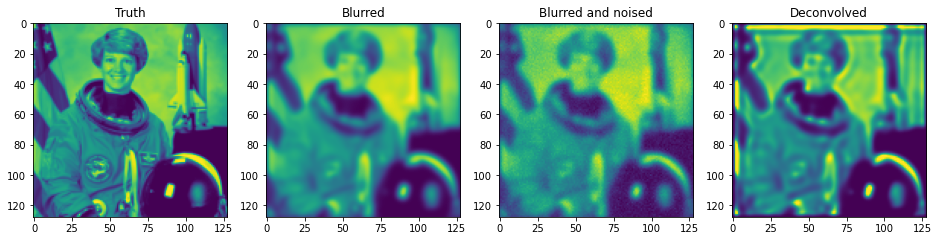

In [356]:
astro = rescale(color.rgb2gray(data.astronaut()), 1.0 / scale)
astro_blur = conv2(astro, static_psf, 'same') # Blur image
astro_corrupt = astro_noisy = astro_blur + (np.random.poisson(lam=25, size=astro_blur.shape) - 10) / 255. # Add Noise to Image
deconvolved_RL = restoration.richardson_lucy(astro_blur, static_psf, iterations=10)  # RL deconvolution

fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(16,7))
ax[0].imshow(astro);ax[0].set_title('Truth')
ax[1].imshow(astro_blur);ax[1].set_title('Blurred')
ax[2].imshow(astro_noisy);ax[2].set_title('Blurred and noised')
ax[3].imshow(deconvolved_RL);ax[3].set_title('Deconvolved');

# Richardson Lucy Deconvolution

We can achieve a model for image formation of an ideal system by generating a measurement matrix $\mathbf{H}$ that acts on the structure $\mathbf{g}$ we are trying to find (assuming the structure is quantised) to produce a pixelated image $\mathbf{f}$ (n-dimensional):

<!-- %%latex -->
\begin{align*}
\underbrace{\mathbf{f}}_\text{Image} &= \overbrace{\mathbf{H}}^\text{Measurement matrix} \underbrace{\mathbf{g}}_\text{Object}\\
\end{align*}

In summation form:

\begin{align*}
f_{N_p}&=\sum_{N_v} H_{N_p, N_v} g_{N_v}\\
 \overbrace{
\begin{bmatrix} 
    f_{11} \\
    \vdots  \\
    f_{N_p}
    \end{bmatrix}
}^{N_p \times 1} \quad &= \overbrace{
\begin{bmatrix} 
    H_{11} & H_{12} & \dots \\
    \vdots & \ddots & \\
    H_{N_v1} &        & H_{N_v N_p} 
    \end{bmatrix}
}^{N_p \times N_v}  \overbrace{
\begin{bmatrix} 
    g_{11} \\
    \vdots  \\
    g_{N_v}
    \end{bmatrix}
}^{N_v \times 1}\\
\end{align*}

In [7]:
N_v = np.ma.size(astro);N_v
N_p = np.ma.size(astro_blur);N_p
measurement_matrix = matrix(np.zeros((N_p, N_v)))

However, the system will be corrupted by noise such that:

\begin{align*}
\mathbf{f}= \mathbf{H} (\mathbf{g}+\mathbf{b})\\
\end{align*}

Assuming $\mathbf{b}$ as being a Poissonian noise distribution we can begin solve the inverse problem of finding $\mathbf{g}$ using maximum liklihood:

\begin{align*}
\operatorname{Pr}(\widehat{\mathbf{f}} | \mathbf{g}, \mathbf{b}) &=\prod_{i}\left(\frac{(H \mathbf{g}+\mathbf{b})_{i}{\widehat{\mathbf{f}}_{i}} \exp \left(-(H \mathbf{g}+\mathbf{b})_{i}\right)}{\widehat{\mathbf{f}}_{i} !}\right)
\end{align*}

It is then possible to solve for $\mathbf{g}$ iteratively giving the iterative Richardson lucy deconvolution algorithm in matrix form:

\begin{align*}
\mathbf{g}^{(k+1)}&=\operatorname{diag}\left(H^{T} \mathbf{1}\right)^{-1} \operatorname{diag}\left(H^{T} \operatorname{diag}\left(H \mathbf{g}^{(k)}+\mathbf{b}\right)^{-1} \mathbf{f}\right) \mathbf{g}^{(k)}
\end{align*}

In convolution notation with a spatially invariant point spread function (P, where P* is the flipped PSF) this can be compressed to:

<!-- %%latex -->
\begin{align*}
\hat{g}^{(t+1)} & =\hat{g}^{(t)} \cdot\left(\frac{f}{\hat{g}^{(t)} \otimes P} \otimes P^{*}\right)
\end{align*}

So, if we know $\mathbf{H}$ and be extension $P$ we can deconvolve any image to retrieve a good approximation of an imaged object

# Knowing $\mathbf{H}$

Knowing $P$ is straightforward either experimentally or theoretically:

For simple optical systems the Point Spread Function can be derived i.e for a perfect lens in a microscope with a glass slide and a liquid interface there is a closed form expression for each of the field components:
\begin{align*}
\begin{array}{l}
h(x, y, z)=\left|I_{0}\right|^{2}+2\left|I_{1}\right|^{2}+\left|I_{2}\right|^{2} \\
I_{0}(x, y, z)=\int_{0}^{\alpha} B_{0}(\theta, x, y, z)\left(t_{s}^{(1)} t_{s}^{(2)}+t_{p}^{(1)} t_{p}^{(2)} \frac{1}{n_{s}} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}\right) d \theta \\
I_{1}(x, y, z)=\int_{0}^{\alpha} B_{1}(\theta, x, y, z)\left(t_{p}^{(1)} t_{p}^{(2)} \frac{n_{i}}{n_{s}} \sin \theta\right) d \theta \\
I_{2}(x, y, z)=\int_{0}^{\alpha} B_{2}(\theta, x, y, z)\left(t_{s}^{(1)} t_{s}^{(2)}+t_{p}^{(1)} t_{p}^{(2)} \frac{1}{n_{s}} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}\right) d \theta \\
B_{m}(\theta, x, y, z)=\sqrt{\cos \theta} \sin \theta J_{m}\left(k \sqrt{x^{2}+y^{2}} n_{i} \sin \theta\right) e^{j W(\theta)} \\
W(\theta)=k\left\{t_{s} \sqrt{n_{s}^{2}-n_{i}^{2} \sin ^{2} \theta}+t_{i} \sqrt{n_{i}^{2}-n_{i}^{2} \sin ^{2} \theta}-t_{i}^{*} \sqrt{n_{i}^{* 2}-n_{i}^{2} \sin ^{2} \theta_{t}}\right. \\
\left.+t_{g} \sqrt{n_{g}^{2}-n_{i}^{2} \sin ^{2} \theta}-t_{g}^{*} \sqrt{n_{g}^{* 2}-n_{i}^{2} \sin ^{2} \theta}\right\}
\end{array}
\end{align*}

Knowing $P$ experimentally relies on capturing images of bright objects that are smaller than the resolution of the instrument.

We then **align and average** these multiple samplings of the PSF to approximate $P$

However, $P$ is known to vary through lens imperfections causing optical abberations, meaning $\mathbf{H}$ is once again useful.

$\mathbf{H}$ can also be written in terms of points spread functions:
\begin{align*}
\begin{bmatrix} 
    f_{1} \\
    \vdots  \\
    f_{N_p}
    \end{bmatrix} \quad =
\begin{bmatrix} 
    P_{1} \\
    \vdots \\
    P_{N_v}
    \end{bmatrix}    
\begin{bmatrix} 
    g_{1} \\
    \vdots  \\
    g_{N_v}
    \end{bmatrix}
\\
\end{align*}

Where $P_n$ is a serialised Point Spread Function at the $n^\text{th}$ serialed pixel poisition. It's also possible to do this with tensors, but serialising is as functional



Now, the difficulty therin lies that we do not know $P_n$ at every $n$; experimentally we know P_n at *most* positions but some form of **interpolation** is needed.

It's fair to assume that the PSF varies smoothly for all $P_n$, but, there are several fringe cases of imaging system where this assumption falls flat and so interpolation alone would not produce a completely general deconvolution algorithm.

<p float="center">
    <img src="moire.png" width="200"/>
    <img src="lightfield.png" width="200"/>
</p>

- **Structured illumination microscopy (SIM)** uses sinusoidally patterned light to increase image resolution
- **Lightfield microscopy** uses an array of microlenes to record a 3D image on a 2D camera

Both have funky spatially varying point spread functions.

# Building $\mathbf{H}$ from simulation

Set up arrays for generating H

In [8]:
zero_image = np.zeros_like(astro)
psf_window_volume = np.full((N_v,psf_window_w, psf_window_h), np.NaN)

x_astro, y_astro = astro_blur.shape
xx_astro, yy_astro = np.meshgrid(np.linspace(-1, 1, x_astro),
                                    np.linspace(-1, 1, y_astro))

Store sinusoidal illumination incase things go well:

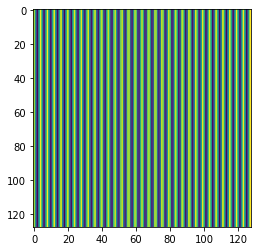

In [9]:
illumination = np.cos(64 / 2 * np.pi * xx_astro)
plt.imshow(illumination)

Define a function that scales the PSF as a function of radial distance

In [10]:
def psf_vary(psf_window_h,psf_window_w,radius,scale):
    return psf_guass(w=round(psf_window_h), h=round(psf_window_w),sigma=(1 / scale)*abs((-0.4*radius))+0.1)

Make the PSF vary across the image (as a function of radius)

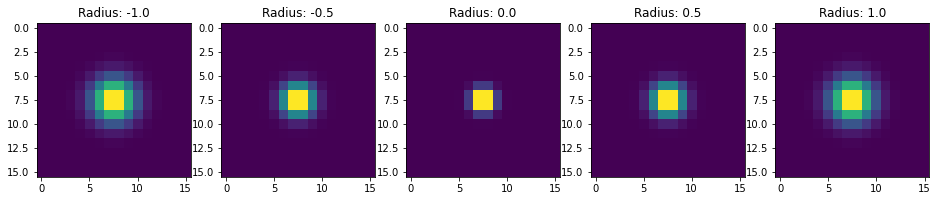

In [11]:
r_map = np.sqrt(xx_astro**2 + yy_astro**2)
radius_samples = np.linspace(-1,1,5)
fig,ax = plt.subplots(nrows=1,ncols=len(radius_samples),figsize=(16,7))

for i,radius in enumerate(np.linspace(-1,1,5)):
    psf_current = psf_vary(psf_window_h,psf_window_w,radius,scale)
    ax[i].imshow(psf_current);ax[i].set_title("Radius: " + str(radius))
plt.show()

In [12]:
psf_switch = psf_switch_enum.VAR_PSF
if(psf_switch==psf_switch_enum.STATIC): filename = "H_staticpsf";
if(psf_switch==psf_switch_enum.VAR_PSF): filename = "H_varpsf";
if(psf_switch==psf_switch_enum.VAR_ILL): filename = "H_varill";

Loop over each row of H and insert a flattened PSF that is the same shape as the input image

In [94]:
for i in tqdm(np.arange(N_v)):
    coords = np.unravel_index(i, np.array(astro.shape))  # Get the xy coordinates of the ith pixel in the original image
    r_dist = r_map[coords]                              # Convert to radius    
    if(psf_switch==psf_switch_enum.STATIC):              # Select mode for generating H, i.e. static/varying psf etc. 
        psf_current = static_psf
    if(psf_switch==psf_switch_enum.VAR_PSF):
        psf_current = psf_vary(psf_window_h,psf_window_w,r_dist,scale);
    if(psf_switch==psf_switch_enum.VAR_ILL):
        psf_current = static_psf* illumination[coords]  

    psf_window_volume[i, :, :] = psf_current
    delta_image = np.zeros_like(astro)
    delta_image[np.unravel_index(i, astro.shape)] = 1
    delta_PSF = scipy.ndimage.convolve(delta_image, psf_current) # Convolve PSF with a image with a single 1 at coord
    
    measurement_matrix[i, :] = delta_PSF.flatten()
    if(SAVE_IMAGES):plt.imshow(psf_current);plt.imsave(f'./output/psfs_new/{str(i).zfill(6)}.png',psf_window_volume[i, :,:])

100%|██████████| 16384/16384 [01:57<00:00, 139.45it/s]


In [95]:
# np.save(filename,measurement_matrix)
# SAVE_IMAGES =0

In [96]:
# measurement_matrix = np.load(filename+".npy")

The resultant measurement matrix, $\mathbf{H}$.

An ideal measurement matrix would have perfect transfer, i.e. be an identity matrix with leading 1s

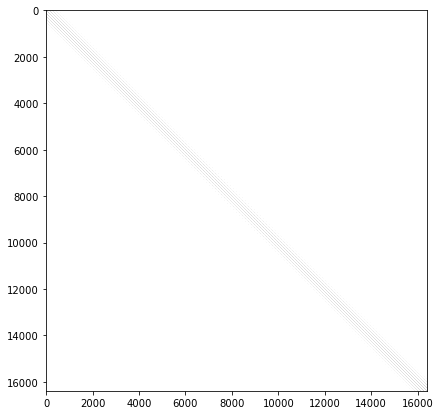

In [97]:
plt.figure(figsize=(18,7))
plt.imshow(exposure.equalize_hist(measurement_matrix),cmap="gray_r")

In [98]:
# measurement_matrix_nuked = exposure.equalize_hist(measurement_matrix)
# # measurement_matrix_nuked[rows_to_nuke,:] = measurement_matrix_nuked.min().min()
# plt.figure(figsize=(18,7))
# plt.imshow(measurement_matrix_nuked,"gray_r")

In [99]:
# plt.imshow(exposure.equalize_hist(measurement_matrix))

In [100]:
# plt.spy(measurement_matrix_nuked,markersize=1)
# measurement_matrix_nuked.min().min()

Import custom RL algorithm, which uses sparse matrices to speedup the matrix calculations 

In [130]:
H = scipy.sparse.linalg.aslinearoperator(measurement_matrix);
g_blurred = H.dot(astro.reshape(-1,1))
# H = scipy.sparse.linalg.aslinearoperator(H_compare);


# f = np.matrix(astro_blur.flatten()).transpose()
f = np.matrix(g_blurred)

In [131]:
# %%timeit
import richardson_lucy
g = richardson_lucy.matrix_reconstruction(H,f,max_iter = 30)

2.000000000000002 2.0000000000000044
	--> [ RL Iteration 0   (0.50 seconds) ] 
	      Residual Norm: 0.5080784586               (tol = 1.000000000000e-06)  
	        Update Norm: 0.001938                              
	--> [ RL Iteration 1   (0.36 seconds) ] 
	      Residual Norm: 0.5053163825               (tol = 1.000000000000e-06)  
	        Update Norm: 6.588e-05                              
	--> [ RL Iteration 2   (0.45 seconds) ] 
	      Residual Norm: 0.5040986603               (tol = 1.000000000000e-06)  
	        Update Norm: 4.262e-05                              
	--> [ RL Iteration 3   (0.43 seconds) ] 
	      Residual Norm: 0.5034361881               (tol = 1.000000000000e-06)  
	        Update Norm: 3.138e-05                              
	--> [ RL Iteration 4   (0.39 seconds) ] 
	      Residual Norm: 0.5030284107               (tol = 1.000000000000e-06)  
	        Update Norm: 2.49e-05                              
	--> [ RL Iteration 5   (0.45 seconds) ] 
	      Residu

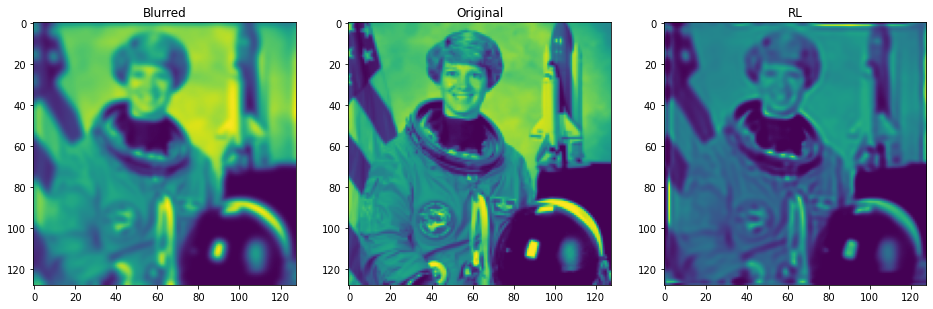

In [132]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(16,7))

ax[0].imshow(g_blurred.reshape(astro.shape));ax[0].set_title("Blurred")
ax[1].imshow(astro);ax[1].set_title("Original")
ax[2].imshow(g.reshape(astro.shape));ax[2].set_title("RL")
plt.show()

# Decomposing $\mathbf{H}$

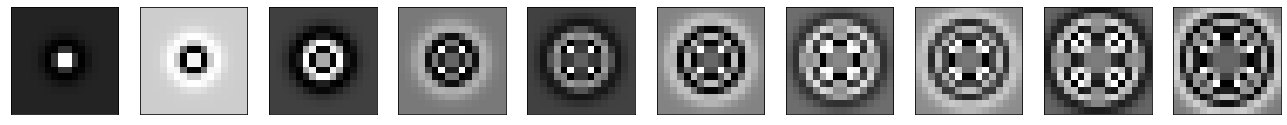

In [104]:
from sklearn.decomposition import PCA, NMF
from sklearn import decomposition

n_samples,psf_width,psf_height = psf_window_volume.shape
n_components = 10
flat_psf = psf_window_volume.reshape(n_samples,-1)


pca = decomposition.PCA(n_components=n_components).fit(flat_psf)

principle_components = pca.transform(flat_psf)
n_samples,n_components = principle_components.shape
eigenfaces = pca.components_.reshape((n_components, psf_height, psf_width))

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        # plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

plot_gallery(eigenfaces, psf_height, psf_width,1, n_components)

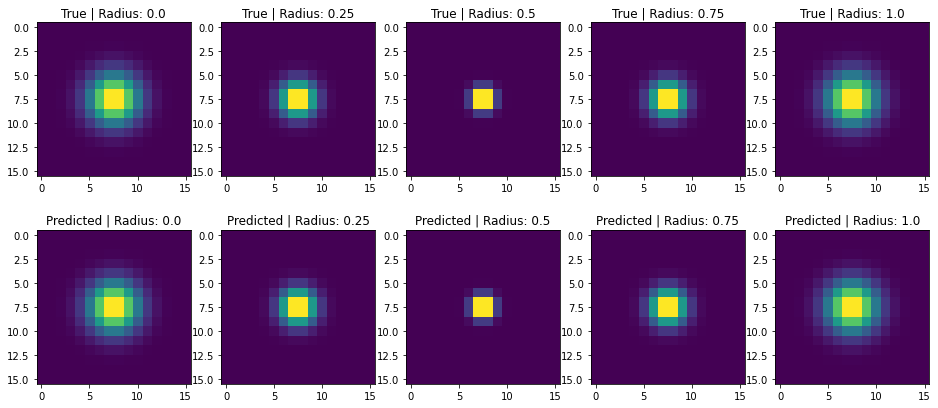

[9.72167717e-01 2.70033852e-02 8.07135452e-04 2.10230681e-05
 7.13936015e-07 2.49654431e-08 6.87738478e-10 3.06491436e-11
 8.78215971e-13 2.57571433e-14]


In [105]:
# https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com
radius_samples = np.linspace(0,1,5)
fig,ax = plt.subplots(nrows=2,ncols=len(radius_samples),figsize=(16,7))

for i,radius in enumerate(radius_samples):
    current_frame = np.rint(np.multiply(np.subtract(astro.shape,1),radius)).astype(int)
    idx = np.ravel_multi_index(current_frame,dims=astro.shape)
    # idx = np.ravel_multi_index(current_frame,dims=(128,128))
    mu = np.mean(flat_psf, axis=0)
    Xhat = np.dot(principle_components[:,:n_components], pca.components_[:n_components,:]) + mu
    # fig,ax = plt.subplots(nrows=1,ncols=len(radius_samples),figsize=(16,7))

    ax[0,i].imshow(psf_window_volume[idx,:,:]);ax[0,i].set_title("True | Radius: " + str(radius))
    ax[1,i].imshow(Xhat[idx].reshape(psf_width,psf_height)); ax[1,i].set_title("Predicted | Radius: " + str(radius))
    # print(current_frame)
    # psf_current = psf_vary(psf_window_h,psf_window_w,radius,scale)
    # ax[i].imshow(psf_current);ax[i].set_title("Radius: " + str(radius))
plt.show()
print(pca.explained_variance_ratio_)

# Modified Richardson Lucy

\begin{gather}
x_{(k+1)}=\frac{x_{(k)}}{H^{T} \cdot 1} H^{T} \frac{y}{H \cdot x^{(k)}} \\
H = \sum_n^\infty D_n \cdot C_n \\
C_n \cdot x = PSF_n * x \\
\end{gather}
\begin{align}
x_{(k+1)}&=\frac{x_{(k)}}{(\sum_n^\infty D_n \cdot C_n)^{T} \cdot 1} (\sum_n^\infty D_n \cdot C_n)^{T} \cdot \frac{y}{(\sum_n^\infty D_n \cdot C_n) \cdot x_{(k)}} \\
x_{(k+1)}&=\frac{x_{(k)}}{(\sum_n^\infty D_n \cdot C_n)^{T} \cdot 1} (\sum_n^\infty C_n^{T} \cdot D_n^{T}) \cdot \frac{y}{(\sum_n^\infty D_n \cdot C_n) \cdot x_{(k)}} \\
x_{(k+1)}&=\frac{x_{(k)}}{(\sum_n^\infty D_n^{T} \cdot (C_n^{T} \cdot 1))} \sum_n^\infty C_n^{T} \cdot (  D_n^{T} \cdot \frac{y}{\sum_n^\infty D_n \cdot (C_n \cdot x_{(k)})}) \\
x_{(k+1)}&=\frac{x_{(k)}}{(\sum_n^\infty D_n^{T} \cdot (PSF_n * 1))} \sum_n^\infty PSF_n * (D_n^{T} \cdot (\frac{y}{\sum_n^\infty D_n \cdot (PSF_n * x_{(k)})})) \\
\end{align}

## Use Pytorch for gradient descent

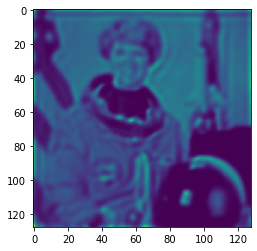

In [377]:
from scipy.signal import convolve
x0 = np.asarray(H.transpose().rmatvec(f)).reshape((-1,))
D_0 = D
D_1 = weigting_1

PSF_0 = mu
ones_2d = np.ones((image.shape))


x = x0
# y = f
g = g_blurred.reshape(astro.shape)

im_deconv = x0.reshape(astro.shape)

image = astro_blur
image = g_blurred.reshape(astro.shape)
# image = y.reshape(astro)

# im_deconv = np.full(image.shape, 0.5)
# im_deconv = x0.reshape(image.shape)
ones = np.ones((image.shape))

psf = PSF_0.reshape((psf_width,psf_height))
psf_0 = PSF_0.reshape((psf_width,psf_height))
# d_1 = 
psf_1 = pca.components_[1,:].reshape((psf_width,psf_height))
weigting_1 = principle_components[:,1].reshape(astro.shape)
# psf = static_psf
psf_mirror = psf

for i in np.arange(0,10):
    conv_0 = convolve(im_deconv, psf_0, mode='same')
    conv_1 = convolve(im_deconv, psf_1, mode='same')
    relative_blur = image / (conv_0+(weigting_1*conv_1))

    scale_1 = convolve(relative_blur, psf_0, mode='same')
    scale_2 = weigting_1*convolve(relative_blur, psf_1, mode='same')

    ones_1 = convolve(ones, psf_0, mode='same')
    ones_2 = weigting_1*convolve(ones, psf_1, mode='same')

    # im_deconv *= convolve(relative_blur, psf_mirror, mode='same')
    im_deconv *= (scale_1+scale_1)/(ones_1+ones_2)

    # if 1:
    #     im_deconv[im_deconv > 1] = 1
    #     im_deconv[im_deconv < -1] = -1

# for i in np.arange(0,30):
#     conv = convolve(im_deconv, psf, mode='same')
#     relative_blur = image / conv
#     im_deconv *= convolve(relative_blur, psf_mirror, mode='same')
#     # if 1:
#     #     im_deconv[im_deconv > 1] = 1
#     #     im_deconv[im_deconv < -1] = -1


# # im_deconv = image
# for i in np.arange(0,30):
#     PSF_conv_x = convolve(im_deconv, psf, mode='same')
#     relative_blur = image/PSF_conv_x
#     # psf_conv_ones = convolve(ones_2d,psf,mode='same')
#     # im_deconv *= (1/psf_conv_ones) * convolve(,psf_mirror, mode='same')
#     im_deconv *= convolve(relative_blur, psf_mirror, mode='same')

#     x_next = signal.convolve(np.divide(y,PSF_conv_x),PSF_0,mode='same')
#     # PSF_conv_1 = signal.convolve(np.ones(x0.shape),PSF_0,mode='same')
#     # a = np.divide(x,(np.multiply(D_0,PSF_conv_1)))
#     # b_bot = np.multiply(D_0,PSF_conv_x)
#     # b = np.multiply(D_0,np.divide(y,b_bot))
#     # b = signal.convolve(np.divide(y,PSF_conv_x),PSF_0,mode="same")
#     # b = scipy.convolve(PSF,PSF_conv_x)
#     # c = signal.convolve(b,PSF_0,mode='same')
#     # x_next = np.multiply(np.divide(x,PSF_conv_1),b)

#     # # b = signal.convolve(PSFs[0], np.ones(x0.shape), mode='same')
#     # x_next = np.multiply(a,c)
#     x = x_next

# # # PSFs[0]

# # signal.convolve(x, np.ones(x0.shape), mode='same')
plt.imshow(im_deconv.reshape(astro.shape))


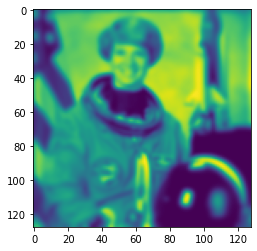

In [367]:
plt.imshow(g)

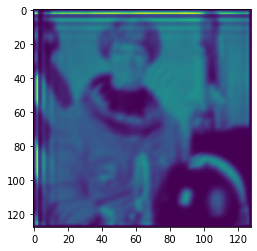

In [351]:
# plt.imshow(psf)

matrix([[0.36639347, 0.3630267 , 0.31263515, ..., 0.26319994, 0.28616632,
         0.30312851]])

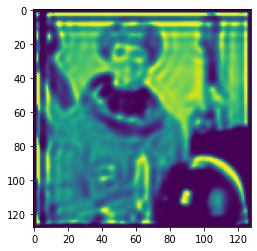

In [342]:
plt.imshow(skimage.restoration.richardson_lucy(astro_blur,static_psf))

In [139]:
import torch

from scipy.linalg import circulant
from scipy.sparse import diags

def make_circulant_from_cropped_psf(psf,in_shape,out_shape):
    padding = np.rint(np.divide((np.subtract(out_shape,in_shape)),2)).astype(int)
    padded_psf = np.pad(psf.reshape(in_shape),pad_width=padding,mode='constant', constant_values=0)
    # rolled_psf = np.roll(padded_psf.flatten(),int(padded_psf.size/2))
    centre_coord = np.ravel_multi_index(np.divide(padded_psf.shape,2).astype(int),dims=padded_psf.shape)
    rolled_psf = np.roll(padded_psf.flatten(),centre_coord)
    C = circulant(rolled_psf)
    return C,rolled_psf

# padding = np.rint(np.divide((np.subtract(astro.shape,(psf_width,psf_height))),2)).astype(int)
# mu_2d = np.pad(mu.reshape(psf_height,psf_width),pad_width=padding,mode='constant', constant_values=0)
# rolled_mu_2d = np.roll(mu_2d.flatten(),int(mu_2d.size/2))
# centre_coord = np.ravel_multi_index(np.divide(mu_2d.shape,2).astype(int),dims=mu_2d.shape)
# C = circulant(np.roll(mu_2d.flatten(),centre_coord))
C,rolled_psf = make_circulant_from_cropped_psf(mu,(psf_width,psf_height),astro.shape)
D = np.ones(C.shape[0])

f = np.asarray(np.matrix(astro_blur.flatten()).transpose()).reshape((-1,))
x0 = np.asarray(H.transpose().rmatvec(f)).reshape((-1,))

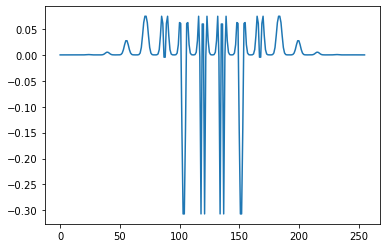

In [140]:
plt.plot(pca.components_[1,:])

In [141]:
Xhat = np.dot(principle_components[:,:1], pca.components_[:1,:])
psf_1 = pca.components_[1,:]
weigting_1 = principle_components[:,1]
C1,rolled_C1 = make_circulant_from_cropped_psf(psf_1,(psf_width,psf_height),astro.shape)
D1C1 = np.multiply(C1,weigting_1)
# # H_recon = 
# # pc1_2d = np.pad(pca.components_[:1,:].reshape(psf_height,psf_width),pad_width=padding,mode='constant', constant_values=0)
# plt.imshow(pc1_2d)
# plt.plot(rolled_C_1)

In [142]:
from skimage.metrics import structural_similarity as ssim
H_compare = D1C1 + C
# print(ssim(H_compare,measurement_matrix))

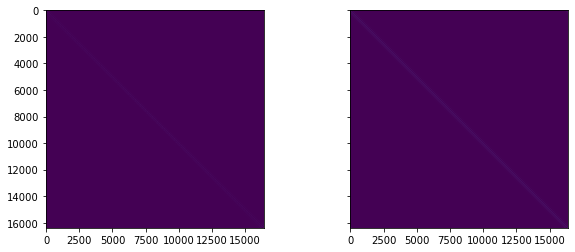

In [143]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                         sharex=True, sharey=True)
axes[0].imshow(measurement_matrix)
axes[1].imshow(H_compare)

In [ ]:
def fft_conv(x: np.ndarray, filters: np.ndarray):
  def conv_fft(x, w, axes):
    def new_shape(shape, pos):
        shape = [i if i else -1 for i in shape]
        shape.insert(pos, 1)
        return shape

    global total_time_2fft, total_time_2fft_rs
    start_event.record()
    # x = tf.signal.fft2d(tf.complex(x, tf.zeros_like(x)))
    x = torch.stack([x, torch.zeros_like(x)], dim=-1)

    x = torch.fft(x, 1)
    x = x.reshape(new_shape(x.shape, axes[0]))           
    w = torch.stack([w, torch.zeros_like(w)], dim=-1)  
    w = torch.fft(w, 1)
    w = w.reshape(new_shape(w.shape, axes[1]))
    conv = complex_edot_sum(x, w, axes[2])
    # print('fft_conv: after THE CONV')

    # torch.cuda.synchronize()
    # print(torch.cuda.memory_allocated()/(1024**2), torch.cuda.memory_cached()/(1024**2),
    # torch.cuda.max_memory_allocated()/(1024**2), torch.cuda.max_memory_cached()/(1024**2))

    start_event.record()
    conv = torch.ifft(conv, 2)[:, :, :, :, 0]

    return conv

In [ ]:
from torch.nn.functional import conv1d
x_torch = torch.tensor(x0,requires_grad=True,dtype=torch.float)

In [166]:

# x_torch = torch.autograd.Variable(torch.tensor(x0,requires_grad=True,dtype=torch.float).unsqueeze(1),requires_grad=True)#.view(x0.shape, 1)
# x = torch.autograd.Variable(torch.rand(dim, 1), requires_grad=True)
stop_loss = 1e-2
step_size = 2 * stop_loss / 3.0

H_torch = torch.tensor(measurement_matrix,dtype=torch.float)
b_torch = torch.tensor(f,dtype=torch.float)
C_torch = torch.tensor(C,dtype=torch.float).to_sparse()
C1_torch = torch.tensor(C1,dtype=torch.float).to_sparse()
D_torch = torch.tensor(D,dtype=torch.float)
D1_torch = torch.tensor(weigting_1,dtype=torch.float)

# print('Loss before: %s' % (torch.norm(torch.matmul(H_torch, x_torch) - b_torch)))
for i in range(1000*1000):
    # working_value = torch.mul(weights_torch,torch.matmul(H_torch,x_torch))

    Cx_torch = torch.matmul(C_torch,x_torch)
    DCx_torch = torch.mul(D_torch,Cx_torch)

    C1x_torch = torch.matmul(C1_torch,x_torch)
    D1C1x_torch = torch.mul(D1_torch,C1x_torch)
    # Ax_torch = torch.matmul(H_torch,x_torch)

    lhs = DCx_torch + D1C1x_torch 

    # Δ = torch.mul(weights_torch,torch.matmul(H_torch,x_torch)) - b_torch
    Δ = lhs - b_torch

    L = torch.norm(Δ, p=2)
    L.backward()
    x_torch.data -= step_size * x_torch.grad.data # step
    x_torch.grad.data.zero_()
    if i % 50 == 0: print('Loss is %s at iteration %i' % (L, i))
    if abs(L) < stop_loss:
        print('It took %s iterations to achieve %s loss.' % (i, step_size))
        break
print('Loss after: %s' % (torch.norm(torch.matmul(A, x_torch) - b_torch)))

Loss is tensor(2.1098, grad_fn=<NormBackward0>) at iteration 0
Loss is tensor(2.1090, grad_fn=<NormBackward0>) at iteration 50
Loss is tensor(2.1083, grad_fn=<NormBackward0>) at iteration 100
Loss is tensor(2.1076, grad_fn=<NormBackward0>) at iteration 150
Loss is tensor(2.1068, grad_fn=<NormBackward0>) at iteration 200
Loss is tensor(2.1061, grad_fn=<NormBackward0>) at iteration 250
Loss is tensor(2.1054, grad_fn=<NormBackward0>) at iteration 300
Loss is tensor(2.1046, grad_fn=<NormBackward0>) at iteration 350
Loss is tensor(2.1039, grad_fn=<NormBackward0>) at iteration 400
Loss is tensor(2.1032, grad_fn=<NormBackward0>) at iteration 450
Loss is tensor(2.1025, grad_fn=<NormBackward0>) at iteration 500
Loss is tensor(2.1017, grad_fn=<NormBackward0>) at iteration 550
Loss is tensor(2.1010, grad_fn=<NormBackward0>) at iteration 600
Loss is tensor(2.1003, grad_fn=<NormBackward0>) at iteration 650
Loss is tensor(2.0996, grad_fn=<NormBackward0>) at iteration 700
Loss is tensor(2.0989, grad_

KeyboardInterrupt: 

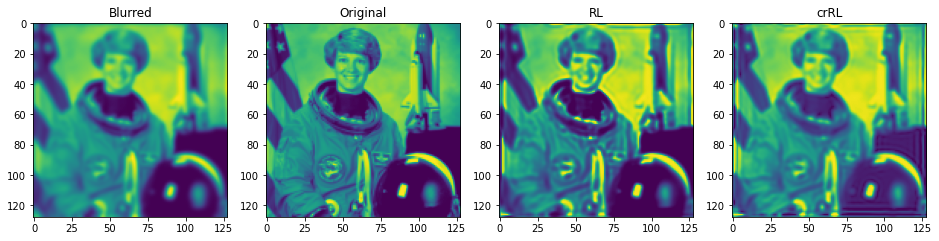

In [172]:
# plt.imshow(x_torch.detach().numpy().reshape(astro.shape))
# plt.imshow(exposure.equalize_hist(x_torch.detach().numpy().reshape(astro.shape)))

fig,ax = plt.subplots(ncols=4,nrows=1,figsize=(16,7))

ax[0].imshow(g_blurred.reshape(astro.shape));ax[0].set_title("Blurred")
ax[1].imshow(astro);ax[1].set_title("Original")
ax[2].imshow(exposure.equalize_hist(g.reshape(astro.shape)));ax[2].set_title("RL")
ax[3].imshow(exposure.equalize_hist(x_torch.detach().numpy().reshape(astro.shape)));ax[3].set_title("crRL")
plt.show()

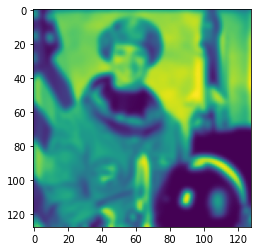

In [150]:
plt.imshow(astro_blur.reshape(astro.shape))

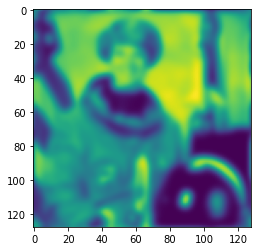

In [151]:
plt.imshow(x0t = torch.sparse.FloatTensor(i.reshape(astro.shape))

# Learning $H$

Assuming we have a decently sized dataset of images of point images we can *try* to fill in the missing rows of $\mathbf{H}$

### Matrix imputation
Known as the netflix problem, attempts to fill in voids in matrices; fails miserably in this case though as entire rows are missing.

In [ ]:
# %% Begin RL matrix deconvolvution - Nuke beads

Remove majority of data randomly

List 1000 random positions

In [24]:
psfs = 1000

rows_to_nuke = np.random.choice(
    np.arange(measurement_matrix.shape[0]), measurement_matrix.shape[0] - psfs,replace=False);rows_to_nuke.shape

(15384,)

Remove rows

In [25]:
psf_window_volume_nuked = psf_window_volume.copy()
psf_window_volume_nuked[rows_to_nuke,:, :] = np.NaN

H_nuked = measurement_matrix.copy()
H_nuked[rows_to_nuke,:] = np.NaN

In [26]:
# imp = IterativeImputer(missing_values=np.nan,verbose=2);
# imp = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=1);
# imp.fit(H_nuked)
# H_fixed = imp.transform(H_nuked)

In [27]:
# h_mse = mean_squared_error(measurement_matrix,H_fixed);h_mse

Save data for machine learning

In [28]:
# # image_width,image_height = np.sqrt(measurement_matrix.shape).astype(np.int)
# image_width,image_height = astro.shape

# H_size_4d = [image_width,image_height,image_width,image_height]

# measurement_matrix_4d_nuked = np.reshape(np.array(H_nuked),array_size_4d)
# measurement_matrix_4d = np.reshape(np.array(measurement_matrix),array_size_4d)

# np.save('data/measurement_matrix_4d_nuked',measurement_matrix_4d_nuked)
# np.save('data/measurement_matrix_4d',measurement_matrix_4d)

# np.save('data/psf_window_volume_nuked',psf_window_volume_nuked)
# np.save('data/psf_window_volume',psf_window_volume)
# psf_window_volume_nuked.shape

# # plt.imsave('./output/H_nuked.png', H_nuked)

## Machine learning H

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
ground_truth = psf_window_volume
train = psf_window_volume.copy()
# train[rows_to_nuke,:,:] = np.NaN

train_4d = train.reshape([int(np.sqrt(train.shape[0])),
                          int(np.sqrt(train.shape[0])),
                          train.shape[1],
                          train.shape[2]])
# X = np.unravel_index(0,train_4d.shape)


In [30]:
X = [np.unravel_index(i,train_4d.shape) for i in np.arange(len(train_4d.flatten()))]
y = train_4d.flatten()

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=1000)

In [32]:
# for i in np.arange(train_4d.flatten().shape):
#     y[i] = train_4d[i]
#     X[i] = np.unravel_index(0,train_4d.shape)

In [33]:
reg = RandomForestRegressor()
reg.fit(X_train,y_train)

RandomForestRegressor()

In [34]:
print(f"Blind : {reg.score(X_test, y_test)}")

Blind : 0.9876209982607368


## Sparse inversion

# Solving sparse linear systems (Ax=b problems)

https://discuss.pytorch.org/t/solving-the-linear-system-of-linear-equations-when-given-the-initial-point/23815/17

https://pytorch.org/docs/stable/generated/torch.solve.html

http://bytepawn.com/pytorch-basics-solving-the-axb-matrix-equation-with-gradient-descent.html

https://botorch.org/tutorials/fit_model_with_torch_optimizer

https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PoissonRegressor.html#sklearn.linear_model.PoissonRegressor

https://scicomp.stackexchange.com/questions/11626/gpu-accelerated-libraries-for-solving-sparse-linear-systems

https://pytorch.org/docs/stable/generated/torch.cholesky_solve.html

https://github.com/PythonOptimizers/SuiteSparse.py
https://github.com/DrTimothyAldenDavis/SuiteSparse


https://discuss.pytorch.org/t/solving-sparse-linear-systems-on-the-gpu/13553

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html#scipy.optimize.lsq_linear
https://docs.cupy.dev/en/stable/reference/generated/cupyx.scipy.sparse.linalg.lsqr.html#cupyx.scipy.sparse.linalg.lsqr



In [162]:
# %%timeit
from scipy.sparse.linalg import lsqr, lsmr, qmr,bicg,cgs
from scipy.sparse import csc_matrix
A = coo_matrix(measurement_matrix)
b = np.array(astro_blur.flatten())
x0 = H.transpose().rmatvec(b)

ValueError: dimension mismatch

In [ ]:
# from scipy.sparse.linalg import inv
# A_inv = inv(A)

In [ ]:
# A_inv

In [38]:
lsmr_out = lsmr(H,b,x0=x0,damp=0.1,show=True,maxiter=30)
print(mean_squared_error(lsmr_out[0],astro_blur.flatten()))
lsqr_out = lsqr(H,b,x0=x0,show=True,iter_lim=30)
print(mean_squared_error(lsqr_out[0],astro_blur.flatten()))
# qmr_out = qmr(H,b,x0=x0,maxiter=30)
# print(mean_squared_error(lsqr_out[0],astro_blur.flatten()))

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 16384 rows and 16384 columns
damp = 1.00000000000000e-01

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       30

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  1.10315e-01  8.615e+00  7.355e+00   1.0e+00  9.9e-02
     1  2.33096e-01  3.071e+00  1.762e+00   4.8e-02  6.3e-01  9.1e-01  1.1e+00
     2  2.96984e-01  1.993e+00  7.215e-01   3.1e-02  3.0e-01  1.2e+00  1.3e+00
     3  3.20336e-01  1.625e+00  3.750e-01   2.6e-02  1.6e-01  1.4e+00  1.6e+00
     4  3.13595e-01  1.463e+00  2.175e-01   2.3e-02  9.2e-02  1.6e+00  1.8e+00
     5  2.93559e-01  1.394e+00  1.446e-01   2.2e-02  5.8e-02  1.8e+00  2.0e+00
     6  2.71098e-01  1.356e+00  1.039e-01   2.1e-02  4.0e-02  1.9e+00  2.1e+00
     7  2.49842e-01  1.332e+00  7.780e-02   2.1e-02  2.8e-02  2.1e+00  2.3e+00
     8  2.30874e-01  1.315e+00  5.953e-02   2.1e-02  2.0e-02  2.2e+00  2.5e+00

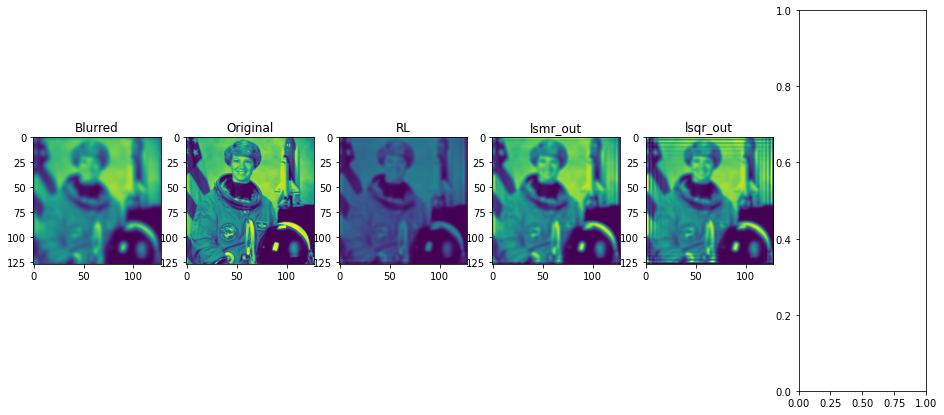

In [39]:
# print(mean_squared_error(out[0],astro_blur.flatten()))
# plt.imshow(out[0].reshape(astro_blur.shape))
# plt.imshow(out[0].reshape(astro_blur.shape))


fig,ax = plt.subplots(ncols=6,nrows=1,figsize=(16,7))

ax[0].imshow(astro_blur,vmin=0, vmax=1);ax[0].set_title("Blurred")
ax[1].imshow(astro,vmin=0, vmax=1);ax[1].set_title("Original")
ax[2].imshow(g.reshape(astro_blur.shape),vmin=0, vmax=1);ax[2].set_title("RL")
ax[3].imshow(lsmr_out[0].reshape(astro_blur.shape),vmin=0, vmax=1);ax[3].set_title("lsmr_out")
ax[4].imshow(lsqr_out[0].reshape(astro_blur.shape),vmin=0, vmax=1);ax[4].set_title("lsqr_out")
# ax[5].imshow(qmr_out[0].reshape(astro_blur.shape));ax[5].set_title("qmr_out")

plt.show()

In [40]:

# from scipy.optimize import lsq_linear

# # lsq_linear_out = lsq_linear(np.array(measurement_matrix),y,bounds=(0,1),verbose=2)
# lsq_linear_out = lsq_linear(coo_matrix(measurement_matrix),y,bounds=(0,1),verbose=2)

# # lsq_linear_out = lsq_linear(H,y,bounds=(0,1),verbose=2)

# print(mean_squared_error(lsq_linear_out[0],astro_blur.flatten()))

# trAb = H.rmatvec(y)

Slow bounded optimiser

In [41]:

# # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html#scipy.optimize.lsq_linear
# # https://docs.cupy.dev/en/stable/reference/generated/cupyx.scipy.sparse.linalg.lsqr.html#cupyx.scipy.sparse.linalg.lsqr
# from scipy.optimize import lsq_linear
# # lsq_linear_out = lsq_linear(np.array(measurement_matrix),b,bounds=(0,1),verbose=2)
# lsq_linear_out = lsq_linear(coo_matrix(measurement_matrix),b,bounds=(0,1),verbose=2)

# # lsq_linear_out = lsq_linear(H,y,bounds=(0,1),verbose=2)

# print(mean_squared_error(lsq_linear_out[0],astro_blur.flatten()))

In [42]:
# print(mean_squared_error(lsq_linear_out[0],astro_blur.flatten()))

## Pytorch gradient descent
### Difficulties convert scipy coo sparse matrices to pytorch
http://bytepawn.com/pytorch-basics-solving-the-axb-matrix-equation-with-gradient-descent.html

In [43]:
import torch
from scipy.sparse import coo_matrix
coo = coo_matrix(measurement_matrix)


values = coo.data
indices = np.vstack((coo.row, coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = coo.shape

A_torch = torch.sparse.FloatTensor(i, v, torch.Size(shape))#.to_dense()
b_torch = torch.tensor(b,requires_grad=False,dtype=torch.float).unsqueeze(1)#.view(b.shape, 1)
x_torch = torch.autograd.Variable(torch.tensor(x0,requires_grad=True,dtype=torch.float).unsqueeze(1),requires_grad=True)#.view(x0.shape, 1)

print('Loss before: %s' % (torch.norm(torch.sparse.mm(A_torch, x_torch) - b_torch)))



Loss before: tensor(0.5340, grad_fn=<NormBackward0>)


In [44]:
def run_fitting(A,b,x,stop_loss=1e-2):
    step_size = stop_loss / 3.0
    print('Loss before: %s' % (torch.norm(torch.sparse.mm(A, x) - b)))
    for i in range(100*20):
        Δ = torch.sparse.mm(A, x) - b
        L = torch.norm(Δ, p=2)
        L.backward()
        x.data -= step_size * x.grad.data # step
        x.grad.data.zero_()
        if i % 100 == 0: print('Loss is %s at iteration %i' % (L, i))
        if abs(L) < stop_loss:
            print('It took %s iterations to achieve %s loss.' % (i, step_size))
            break
    print('Loss after: %s' % (torch.norm(torch.sparse.mm(A, x) - b)))
    return x
x = run_fitting(A=A_torch,b=b_torch,x=x_torch)

Loss before: tensor(0.5340, grad_fn=<NormBackward0>)
Loss is tensor(0.5340, grad_fn=<NormBackward0>) at iteration 0
Loss is tensor(0.5219, grad_fn=<NormBackward0>) at iteration 100
Loss is tensor(0.5143, grad_fn=<NormBackward0>) at iteration 200
Loss is tensor(0.5089, grad_fn=<NormBackward0>) at iteration 300
Loss is tensor(0.5046, grad_fn=<NormBackward0>) at iteration 400
Loss is tensor(0.5011, grad_fn=<NormBackward0>) at iteration 500
Loss is tensor(0.4979, grad_fn=<NormBackward0>) at iteration 600
Loss is tensor(0.4951, grad_fn=<NormBackward0>) at iteration 700
Loss is tensor(0.4926, grad_fn=<NormBackward0>) at iteration 800
Loss is tensor(0.4902, grad_fn=<NormBackward0>) at iteration 900
Loss is tensor(0.4879, grad_fn=<NormBackward0>) at iteration 1000
Loss is tensor(0.4858, grad_fn=<NormBackward0>) at iteration 1100
Loss is tensor(0.4839, grad_fn=<NormBackward0>) at iteration 1200
Loss is tensor(0.4820, grad_fn=<NormBackward0>) at iteration 1300
Loss is tensor(0.4801, grad_fn=<Nor

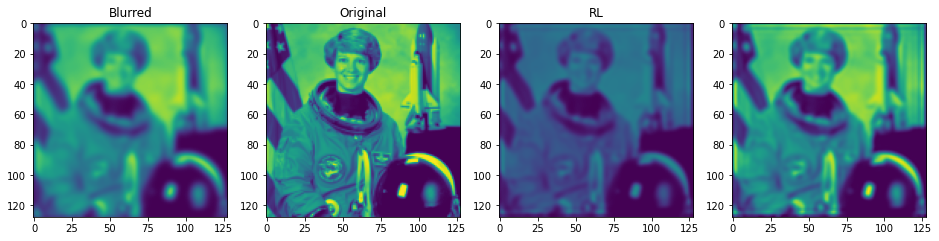

In [45]:
fig,ax = plt.subplots(ncols=4,nrows=1,figsize=(16,7))

ax[0].imshow(astro_blur,vmin=0, vmax=1);ax[0].set_title("Blurred")
ax[1].imshow(astro,vmin=0, vmax=1);ax[1].set_title("Original")
ax[2].imshow(g.reshape(astro_blur.shape),vmin=0, vmax=1);ax[2].set_title("RL")
ax[3].imshow(x.detach().numpy().reshape(astro_blur.shape),vmin=0, vmax=1)

# ax[5].imshow(qmr_out[0].reshape(astro_blur.shape));ax[5].set_title("qmr_out")

plt.show()

In [46]:
def to_sparse(x):
    """ converts dense tensor x to sparse format """
    x_typename = torch.typename(x).split('.')[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())

## Iterative "direct solvers" unsurprisingly do not work

In [47]:
# plt.imshow(x.reshape(astro_blur.shape))

# from scipy.sparse.linalg import lsqr, qmr, lsmr

# x = spsolve(A,b)
# x = lsqr(A,b)
# x = lsmr(A,b)
# x = qmr(A,b)
# print(mean_squared_error(x,astro_blur.flatten()))


## Using linear weighted regression and sklearn
Works well with lasso/ elastic net

In [48]:
from sklearn.linear_model import LinearRegression, Lasso,ElasticNet, TweedieRegressor
# y = 
b = np.array(astro_blur.flatten())
reg = ElasticNet(positive=True,fit_intercept=False,alpha=0.01)
# out = reg.path(X=measurement_matrix, y=b,verbose=1,positive=True,coef_init=x0)
out = reg.path(X=A, y=b,verbose=2,positive=True,coef_init=x0,max_iter=30,n_alphas=10)
alpha, coefs, dual_gaps = out
# out = reg.path(X=H, y=b,verbose=1,positive=True,coef_init=x0)

# out = reg.path(X=H, y=b,verbose="True",positive=True,coef_init=x0)

# params = {"verbose":True}
# reg.set_params(**params)
# reg.get_params()
# reg.fit(measurement_matrix, b)
# print(reg.coef_)


Path: 000 out of 010
Path: 001 out of 010
Path: 002 out of 010
Path: 003 out of 010
Path: 004 out of 010
Path: 005 out of 010
Path: 006 out of 010
Path: 007 out of 010
Path: 008 out of 010
Path: 009 out of 010


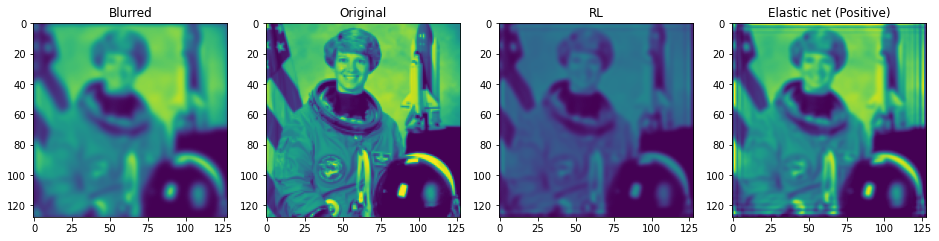

In [49]:
fig,ax = plt.subplots(ncols=4,nrows=1,figsize=(16,7))

ax[0].imshow(astro_blur,vmin=0, vmax=1);ax[0].set_title("Blurred")
ax[1].imshow(astro,vmin=0, vmax=1);ax[1].set_title("Original")
ax[2].imshow(g.reshape(astro_blur.shape),vmin=0, vmax=1);ax[2].set_title("RL")
ax[3].imshow(coefs[:,-1].reshape(astro_blur.shape),vmin=0, vmax=1);ax[3].set_title("Elastic net (Positive)")

# ax[5].imshow(qmr_out[0].reshape(astro_blur.shape));ax[5].set_title("qmr_out")

plt.show()

Tweedle doesn't work for reasons

In [50]:
# from sklearn.linear_model import TweedieRegressor
# reg = TweedieRegressor(fit_intercept=False, max_iter=1000, warm_start=True, verbose=10)
# reg.coef_ = x0
# out = reg.fit(X=measurement_matrix,y=b)

In [51]:
# from sklearn.linear_model import TweedieRegressor
# reg = TweedieRegressor(fit_intercept=False, max_iter=1000, warm_start=True, verbose=10)
# reg.coef_ = x0
# out = reg.fit(X=measurement_matrix,y=b)

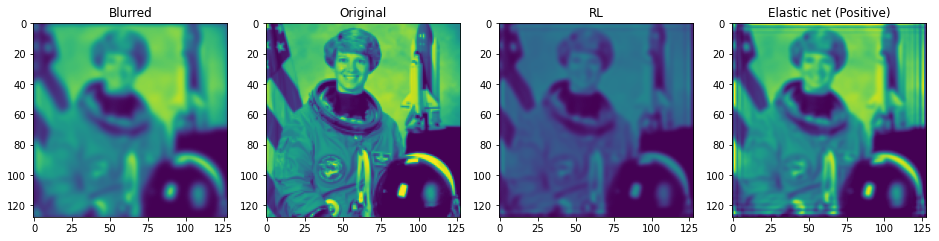

In [52]:
coefs[:,-1].max()

1.0898484072008447

## Pseudo matrix inversion
Using penrose' method for pure matrix inversion, non iterative solution, but seems to fail miserably?

In [53]:
from scipy.sparse.linalg import inv

A = coo_matrix(measurement_matrix)
# H_i = inv(A)
# eye = H_i @ A
b = astro_blur.flatten()

In [54]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, coo_matrix
A = csc_matrix(measurement_matrix)
A = coo_matrix(measurement_matrix)

b = f


    Linear sum of sparse matrix and toeplitz could decrease overall computation time.
    Intelligent scaling of step sizes in least squares to ensure non-negativity
    Look up how dense least squares (land webber) enforces non-negativity.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html#scipy.optimize.lsq_linear
        Does this apply to sparse solvers?
    Lookup difference between Andy's method for RL deconvolution and Broxton version (implement both).
